Libraries imported successfully.
Loading saved model and test data:
Artifacts loaded successfully.
Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient',...
       'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'primary_diag_group'],
      dtype='object'))])),
                ('m

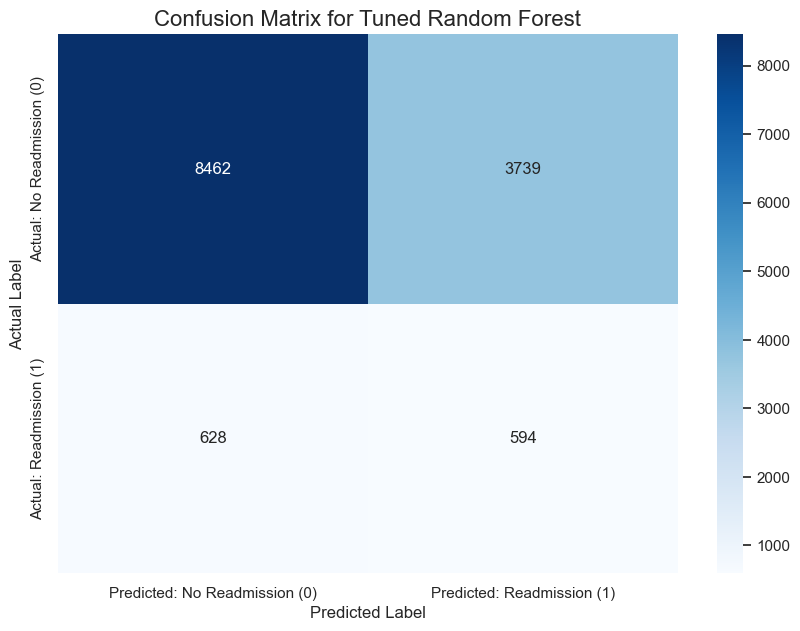

This heatmap visually confirms your results:
True Positives (Found At-Risk): 594
False Negatives (Missed At-Risk): 628
False Positives (False Alarms): 3739

Generating Visualization 2: Precision-Recall Curve


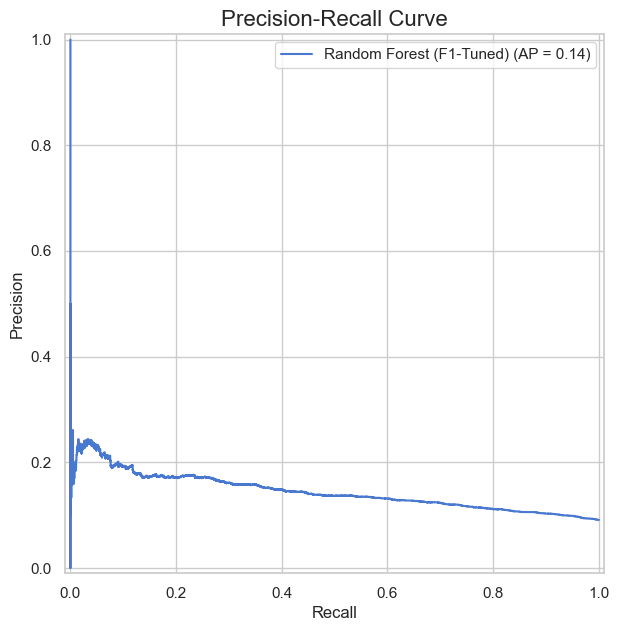

Average Precision (AP): 0.1447
This curve shows the 'menu' of options. By changing the probability threshold,
you can trade precision for recall. Your model's 50% threshold is just one point on this line.

Generating Visualization 3: Feature Importance


C:\Users\akars\AppData\Local\Temp\ipykernel_3388\1638700727.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15_features.values, y=top_15_features.index, palette='viridis')


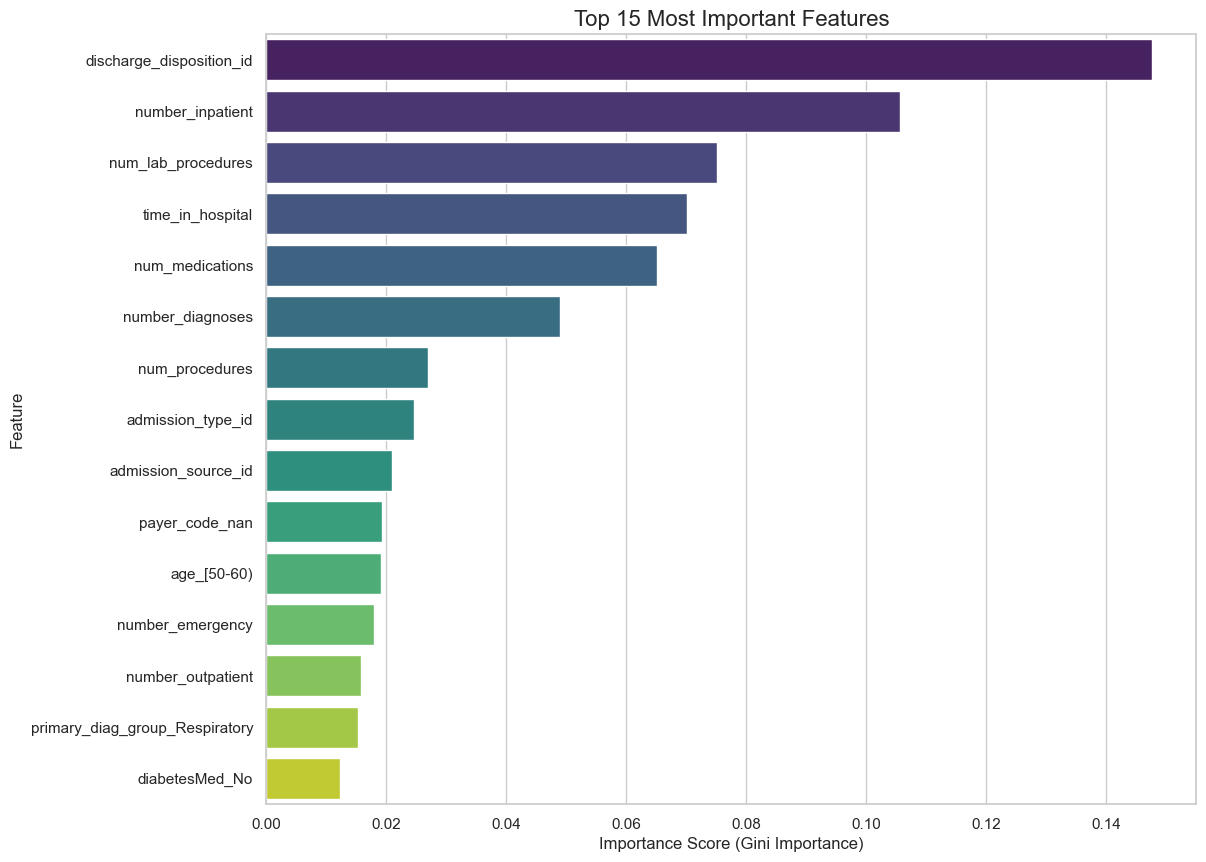


=== Visualization Notebook Complete ===


In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    PrecisionRecallDisplay,
    average_precision_score,
)

# styling
%matplotlib inline
sns.set(style="whitegrid", palette="muted")
print("Libraries imported successfully.")

print("Loading saved model and test data:")
try:
    # Load the tuned pipeline
    pipeline = joblib.load('rf_tuned_pipeline.joblib')

    # Load the test data
    X_test = pd.read_csv('X_test.csv')
    y_test = pd.read_csv('y_test.csv').squeeze() # .squeeze() converts it from a DataFrame to a Series

    print("Artifacts loaded successfully.")
    print(f"Model: {pipeline}")
    print(f"Test data shape: {X_test.shape}")

except FileNotFoundError as e:
    print(f"Error: Could not find a required file. {e}")
    print("Please ensure 'rf_f1_tuned_pipeline.joblib', 'X_test.csv', and 'y_test.csv' are in the same directory.")
    # Stop execution if files aren't found
    raise

# predictions
print("\nGenerating predictions on the test set:")
# Get class predictions (0 or 1)
y_pred = pipeline.predict(X_test)

# This is crucial for the P-R curve
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print("Predictions generated.")
print("\nFinal Classification Report: ")
print(classification_report(y_test, y_pred, target_names=['Not Readmitted (0)', 'Readmitted (1)']))

print("\nGenerating Visualization 1: Confusion Matrix")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: No Readmission (0)', 'Predicted: Readmission (1)'],
            yticklabels=['Actual: No Readmission (0)', 'Actual: Readmission (1)'])

plt.title('Confusion Matrix for Tuned Random Forest', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

print("This heatmap visually confirms your results:")
print(f"True Positives (Found At-Risk): {cm[1, 1]}")
print(f"False Negatives (Missed At-Risk): {cm[1, 0]}")
print(f"False Positives (False Alarms): {cm[0, 1]}")


print("\nGenerating Visualization 2: Precision-Recall Curve")
# This is the most important plot for your trade-off discussion.
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 7))
display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_precision)
display.plot(ax=plt.gca(), name='Random Forest (F1-Tuned)')

plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right')
plt.show()

print(f"Average Precision (AP): {avg_precision:.4f}")
print("This curve shows the 'menu' of options. By changing the probability threshold,")
print("you can trade precision for recall. Your model's 50% threshold is just one point on this line.")


print("\nGenerating Visualization 3: Feature Importance")

try:
    # Get the model step
    model = pipeline.named_steps['model']

    # Get the preprocessor step
    preprocessor = pipeline.named_steps['preprocessor']

    # Get the feature names from the preprocessor's transformers
    # 1. Numerical features (they are passed through in order)
    num_features = preprocessor.transformers_[0][2]

    # 2. Categorical features (get from the OneHotEncoder)
    cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(
        preprocessor.transformers_[1][2] # Pass in the original categorical column names
    )

    # 3. Combine them into one list
    all_feature_names = np.concatenate([num_features, cat_features])

    # Create a pandas Series for easy plotting
    importances = pd.Series(model.feature_importances_, index=all_feature_names)

    # Get the Top 15 most important features
    top_15_features = importances.nlargest(15)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.barplot(x=top_15_features.values, y=top_15_features.index, palette='viridis')
    plt.title('Top 15 Most Important Features', fontsize=16)
    plt.xlabel('Importance Score (Gini Importance)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

except Exception as e:
    print(f"\nError retrieving feature importances: {e}")
    print("This step can be complex. Ensure your pipeline structure is 'preprocessor' -> 'model'.")

print("\n=== Visualization Notebook Complete ===")